In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Project Luther Data Cleaning, Feature Engineering, and Analysis 

In [196]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
%matplotlib inline

# Load Data from local files

In [197]:
################## Make it this way (the fast way) for the blog post
# load data into list of lists and then put it into pandas
##################

allFiles = glob.glob("/Users/williamcosby/Documents/metis/Project_Luther/movie_*.csv")
movie_data = pd.DataFrame()
list_ = []
for file_ in allFiles:
    df = pd.read_csv(file_,index_col=None, header=0)
    list_.append(df)
movie_data_raw = pd.concat(list_)

In [198]:
# movie_data_2015_2016 = pd.read_csv('movie_data_2015_2016.csv')

In [199]:
movie_data_raw.head()

,MOVIE_NAME,DOMESTIC_OPENING,FOREIGN_TOTAL,BUDGET,GENRE,RELEASE_DATE
0,Marvel's The Avengers,207438708,896200000,220000000.0,Action / Adventure,2012-05-04 00:00:00
1,The Dark Knight Rises,160887295,636800000,250000000.0,Action Thriller,2012-07-20 00:00:00
2,The Hunger Games,152535747,286384032,78000000.0,Action / Adventure,2012-03-23 00:00:00
3,Skyfall,88364714,804200736,200000000.0,Action,2012-11-09 00:00:00
4,The Hobbit:An Unexpected Journey,84617303,718100000,0.0,Fantasy,2012-12-14 00:00:00


# Set the index to the movie name (for the merges and analysis later on)

In [200]:
movie_data_raw = movie_data_raw.set_index(['MOVIE_NAME'])

# Read in director, writer, actor, and producer information

In [201]:
director_data_raw = pd.read_csv('/Users/williamcosby/Documents/metis/Project_Luther/director_data.csv')
actor_data_raw = pd.read_csv('/Users/williamcosby/Documents/metis/Project_Luther/actor_data.csv')
writer_data_raw = pd.read_csv('/Users/williamcosby/Documents/metis/Project_Luther/writer_data.csv')
producer_data_raw = pd.read_csv('/Users/williamcosby/Documents/metis/Project_Luther/producer_data.csv')

### All of this data is in format: Movie Name, Person

In [202]:
producer_data_raw.head(5)

,MOVIE_NAME,PRODUCER
0,Finding Dory,Thomas Newman
1,Captain America:Civil War,Kevin Feige
2,Captain America:Civil War,Henry Jackman
3,Deadpool,Lauren Schuler Donner
4,Deadpool,Simon Kinberg


### make the movie name the index

In [203]:
director_data = director_data_raw.set_index(['MOVIE_NAME'])
writer_data = writer_data_raw.set_index(['MOVIE_NAME'])
actor_data = actor_data_raw.set_index(['MOVIE_NAME'])
producer_data = producer_data_raw.set_index(['MOVIE_NAME'])

In [204]:
director_data.head(5)

,DIRECTOR
MOVIE_NAME,
Finding Dory,Andrew Stanton
Captain America:Civil War,Anthony Russo
Captain America:Civil War,Joe Russo
The Jungle Book (2016),Jon Favreau
Zootopia,Rich Moore


In [205]:
actor_data.head(5)

,ACTOR
MOVIE_NAME,
Finding Dory,Ellen DeGeneres
Finding Dory,Albert Brooks
Finding Dory,Ty Burrell*
Finding Dory,Diane Keaton*
Finding Dory,Idris Elba*


In [206]:
writer_data.head(5)

,WRITER
MOVIE_NAME,
Finding Dory,Andrew Stanton
Captain America:Civil War,Christopher Markus
Captain America:Civil War,Stephen McFeely
Deadpool,Rhett Reese
Deadpool,Paul Wernick


In [207]:
producer_data.head(5)

,PRODUCER
MOVIE_NAME,
Finding Dory,Thomas Newman
Captain America:Civil War,Kevin Feige
Captain America:Civil War,Henry Jackman
Deadpool,Lauren Schuler Donner
Deadpool,Simon Kinberg


### Vectorize the data

#### Creates a dataframe with the name of each person as a column, and the movies as the rows, if the person was involved with the movie then the value for that cell is 1, if they weren't involved the value is 0

In [208]:
def vectorize_director(row):
    row[row['DIRECTOR']] = 1
    return pd.Series(row)
def vectorize_writer(row):
    row[row['WRITER']] = 1
    return pd.Series(row)
def vectorize_producer(row):
    row[row['PRODUCER']] = 1
    return pd.Series(row)
def vectorize_actor(row):
    row[row['ACTOR']] = 1
    return pd.Series(row)

In [209]:
director_data = director_data.apply(vectorize_director,axis=1).fillna(0)
writer_data = writer_data.apply(vectorize_writer,axis=1).fillna(0)
producer_data = producer_data.apply(vectorize_producer,axis=1).fillna(0)
actor_data = actor_data.apply(vectorize_actor,axis=1).fillna(0)

In [210]:
# drop the original column that still has the names

director_data.drop(['DIRECTOR'],inplace=True)
actor_data.drop(['ACTOR'],inplace=True)
producer_data.drop(['PRODUCER'],inplace=True)
writer_data.drop(['WRITER'],inplace=True)


## Collapse the rows onto eachother if they are the same movie (so each movie is only in there once and each person is no longer a one hot vector)

In [211]:
director_data_collapsed = director_data.groupby(director_data.index).sum()
actor_data_collapsed = actor_data.groupby(actor_data.index).sum()
writer_data_collapsed = writer_data.groupby(writer_data.index).sum()
producer_data_collapsed = producer_data.groupby(producer_data.index).sum()

## Want to multiply every value in each column by the sum of that column...this represents the person's experience

In [212]:
def sum_exp(row):
    row = row*row.sum(axis=0)
    return pd.Series(row)

## Transpose the data frame to make it easier to the sum the "experience" of each person

In [213]:
director_data_transpose = director_data_collapsed.transpose()
director_data_transpose_summed = director_data_transpose.apply(sum_exp,axis=1)
director_data = director_data_transpose_summed.transpose()
# director_data.head(10)

actor_data_transpose = actor_data_collapsed.transpose()
actor_data_transpose_summed = actor_data_transpose.apply(sum_exp,axis=1)
actor_data = actor_data_transpose_summed.transpose()

writer_data_transpose = writer_data_collapsed.transpose()
writer_data_transpose_summed = writer_data_transpose.apply(sum_exp,axis=1)
writer_data = writer_data_transpose_summed.transpose()

producer_data_transpose = producer_data_collapsed.transpose()
producer_data_transpose_summed = producer_data_transpose.apply(sum_exp,axis=1)
producer_data = producer_data_transpose_summed.transpose()

## Create a column of the role's total experience for that movie:

### so it will be: movie name, total of movie's persons' exp

In [214]:
director_data['DIRECTOR_EXP'] = director_data.sum(axis=1)
director_experience = director_data['DIRECTOR_EXP']
director_experience = director_experience.to_frame('DIRECTOR_EXP')

actor_data['ACTOR_EXP'] = actor_data.sum(axis=1)
actor_experience = actor_data['ACTOR_EXP']
actor_experience = actor_experience.to_frame('ACTOR_EXP')

producer_data['PRODUCER_EXP'] = producer_data.sum(axis=1)
producer_experience = producer_data['PRODUCER_EXP']
producer_experience = producer_experience.to_frame('PRODUCER_EXP')

writer_data['WRITER_EXP'] = writer_data.sum(axis=1)
writer_experience = writer_data['WRITER_EXP']
writer_experience = writer_experience.to_frame('WRITER_EXP')

In [215]:
director_experience.describe()

,DIRECTOR_EXP
count,1147.00000
mean,2.51177
std,1.44068
min,1.00000
25%,1.00000
50%,2.00000
75%,3.00000
max,8.00000


In [216]:
actor_experience.head()

,ACTOR_EXP
MOVIE_NAME,
'71,6.0
10 Cloverfield Lane,9.0
10 Years,99.0
12 Years a Slave,95.0
127 Hours,23.0


In [217]:
actor_experience.describe()

,ACTOR_EXP
count,1639.000000
mean,28.258694
std,21.533067
min,1.000000
25%,12.000000
50%,23.000000
75%,40.000000
max,182.000000


# Now need to merge the datasets

#### currently stored in individual data frames, want one big one that looks like:
#### movie name, total of movie's persons' exp, total of movie's directors' exp, total of movie's producers' exp, total of movie's writers' exp

In [218]:
direct_act_joined = director_experience.join(actor_experience)
direct_act_prod_joined = direct_act_joined.join(producer_experience)
full_people_joined = direct_act_prod_joined.join(writer_experience)

In [219]:
full_people_joined.head()

,DIRECTOR_EXP,ACTOR_EXP,PRODUCER_EXP,WRITER_EXP
MOVIE_NAME,,,,
10 Years,1.0,99.0,14.0,2.0
11-11-11,1.0,NaN,NaN,1.0
12 Years a Slave,2.0,95.0,72.0,3.0
127 Hours,3.0,23.0,5.0,5.0
13 Hours:The Secret Soldiers of Benghazi,4.0,8.0,NaN,NaN


# Join people data with the full dataset

Joinin on movie_name as the index

In [220]:
movie_data_raw = movie_data_raw.join(full_people_joined)

# Find number of movies that have foreign gross info

In [221]:
movie_data_raw.columns

Index([u'DOMESTIC_OPENING', u'FOREIGN_TOTAL', u'BUDGET', u'GENRE',
       u'RELEASE_DATE', u'DIRECTOR_EXP', u'ACTOR_EXP', u'PRODUCER_EXP',
       u'WRITER_EXP'],
      dtype='object')

In [222]:
# total number of movies
movie_data_raw.shape

(4256, 9)

In [223]:
# movies with foreign earnings information
movie_data_raw[movie_data_raw['FOREIGN_TOTAL']!=0].shape

(1528, 9)

# Subset to get just the movies with foreign earnings information

In [224]:
movie_data = movie_data_raw[movie_data_raw['FOREIGN_TOTAL']!=0]

In [225]:
movie_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1528 entries, '71 to [Rec] 2
Data columns (total 9 columns):
DOMESTIC_OPENING    1528 non-null int64
FOREIGN_TOTAL       1528 non-null int64
BUDGET              1527 non-null float64
GENRE               1528 non-null object
RELEASE_DATE        1528 non-null object
DIRECTOR_EXP        883 non-null float64
ACTOR_EXP           810 non-null float64
PRODUCER_EXP        762 non-null float64
WRITER_EXP          711 non-null float64
dtypes: float64(5), int64(2), object(2)
memory usage: 119.4+ KB


# Start cleaning the main data frame

## Combine the genres so they arent "action / adventure", but want to maintain that the movie was action AND adventure

In [226]:
def split_genres(row):
    genres=[]
    if '/' in row['GENRE']:
        genres = row['GENRE'].split('/')
    else:
        genres = row['GENRE'].split()
    for genre in genres:
        # need to strip the whitespace off the columns to avoid things like 'Action' and 'Action '
        row[genre.strip()] = 1
    return pd.Series(row)

In [227]:
movie_data_split = movie_data.apply(split_genres,axis=1)

In [228]:
movie_data_split.head(3)

,ACTOR_EXP,Action,Adventure,Animation,BUDGET,Comedy,Concert,Crime,DIRECTOR_EXP,DOMESTIC_OPENING,...,Period,RELEASE_DATE,Romance,Romantic,Sci-Fi,Sports,Thriller,WRITER_EXP,War,Western
MOVIE_NAME,,,,,,,,,,,,,,,,,,,,,
'71,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,55761,...,NaN,2015-02-27 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
10 Cloverfield Lane,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,24727437,...,NaN,2016-03-11 00:00:00,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
11-11-11,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0,32771,...,NaN,2011-11-11 00:00:00,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN


## Now fill in the missing values with 0


In [229]:
movie_data = movie_data_split.fillna(0)

## Need to drop the 'GENRE' column now

In [230]:
movie_data.drop(['GENRE'],axis=1,inplace=True)

In [231]:
movie_data.columns

Index([u'ACTOR_EXP', u'Action', u'Adventure', u'Animation', u'BUDGET',
       u'Comedy', u'Concert', u'Crime', u'DIRECTOR_EXP', u'DOMESTIC_OPENING',
       u'Documentary', u'Drama', u'FOREIGN_TOTAL', u'Family', u'Fantasy',
       u'Foreign', u'Historical', u'Horror', u'IMAX', u'Music', u'Musical',
       u'PRODUCER_EXP', u'Period', u'RELEASE_DATE', u'Romance', u'Romantic',
       u'Sci-Fi', u'Sports', u'Thriller', u'WRITER_EXP', u'War', u'Western'],
      dtype='object')

In [232]:
movie_data.head(2)

,ACTOR_EXP,Action,Adventure,Animation,BUDGET,Comedy,Concert,Crime,DIRECTOR_EXP,DOMESTIC_OPENING,...,Period,RELEASE_DATE,Romance,Romantic,Sci-Fi,Sports,Thriller,WRITER_EXP,War,Western
MOVIE_NAME,,,,,,,,,,,,,,,,,,,,,
'71,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55761,...,0.0,2015-02-27 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
10 Cloverfield Lane,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24727437,...,0.0,2016-03-11 00:00:00,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


### Will want to encode the dates as 1st quarter, 2nd quarter, 3rd quarter, 4th quarter
#### Do this by first transforming the column into strings "1","2","3","4", then apply pandas .get_dummies to make it one-hot

In [233]:
from pandas import DatetimeIndex
import dateutil.parser

In [234]:
# turn RELEASE_DATE into actual datetime
movie_data['RELEASE_DATE'] = movie_data['RELEASE_DATE'].apply(lambda x: dateutil.parser.parse(x))

In [235]:
movie_data['RELEASE_DATE'].dtype

dtype('<M8[ns]')

In [236]:
movie_data["RELEASE_QUARTER"] = movie_data["RELEASE_DATE"].apply(lambda x: x.quarter)

In [237]:
# now just want release quarter
movie_data.drop(['RELEASE_DATE'],axis=1,inplace=True)

#### Now vectorize release quarter column

In [238]:
movie_data = pd.get_dummies(movie_data,columns=["RELEASE_QUARTER"])

In [239]:
movie_data.head()

,ACTOR_EXP,Action,Adventure,Animation,BUDGET,Comedy,Concert,Crime,DIRECTOR_EXP,DOMESTIC_OPENING,...,Sci-Fi,Sports,Thriller,WRITER_EXP,War,Western,RELEASE_QUARTER_1,RELEASE_QUARTER_2,RELEASE_QUARTER_3,RELEASE_QUARTER_4
MOVIE_NAME,,,,,,,,,,,,,,,,,,,,,
'71,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55761,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
10 Cloverfield Lane,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24727437,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
11-11-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,32771,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
12 Years a Slave,95.0,0.0,0.0,0.0,20000000.0,0.0,0.0,0.0,2.0,7599446,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0
127 Hours,23.0,0.0,0.0,0.0,18000000.0,0.0,0.0,0.0,3.0,2401652,...,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,1.0


# Check the data for missing values, and other weird things

## Impute what I can into the raw data

### Check Domestic Openings

In [240]:
len(movie_data[movie_data["DOMESTIC_OPENING"] == 0])

0

## Check Budget 

In [241]:
# woah...missing a lot~~
len (movie_data[movie_data['BUDGET'] == 0])

774

In [242]:
movie_no_budget = movie_data[movie_data['BUDGET'] == 0]

In [243]:
movie_no_budget.head(10)

,ACTOR_EXP,Action,Adventure,Animation,BUDGET,Comedy,Concert,Crime,DIRECTOR_EXP,DOMESTIC_OPENING,...,Sci-Fi,Sports,Thriller,WRITER_EXP,War,Western,RELEASE_QUARTER_1,RELEASE_QUARTER_2,RELEASE_QUARTER_3,RELEASE_QUARTER_4
MOVIE_NAME,,,,,,,,,,,,,,,,,,,,,
'71,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55761,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
10 Cloverfield Lane,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24727437,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
11-11-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,32771,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
13 Assassins,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45854,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
17 Girls,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4449,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2 Days in New York,11.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,23942,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0
"20,000 Days on Earth",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27879,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3 (2011),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9821,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
360,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12186,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [48]:
movies_no_domestic = movie_data[movie_data["DOMESTIC_OPENING"] == 0]

In [49]:
movies_no_domestic

,ACTOR_EXP,Action,Adventure,Animation,BUDGET,Comedy,Concert,Crime,DIRECTOR_EXP,DOMESTIC_OPENING,...,Sci-Fi,Sports,Thriller,WRITER_EXP,War,Western,RELEASE_QUARTER_1,RELEASE_QUARTER_2,RELEASE_QUARTER_3,RELEASE_QUARTER_4
MOVIE_NAME,,,,,,,,,,,,,,,,,,,,,


# Get rid of entries with no budget info

In [244]:
movie_data = movie_data[movie_data['BUDGET'] != 0]

In [245]:
movie_data[movie_data['FOREIGN_TOTAL'] >= 0].shape

(754, 35)

In [246]:
movie_data.shape

(754, 35)

In [247]:
len(movie_data[movie_data['Foreign'] == 1])

9

# Drop foreign movies because they dont record foreign and domestic information in a meaningful way (i.e. a movie made in korea and listed in box office mojo has domestic earnings as what it made in the us, not korea...so the foreign earnings are what that movie made in its home country.  This is not going to fit with any general trends of movies made in the us

In [248]:
movie_data = movie_data[movie_data['Foreign'] == 0] 

In [249]:
movie_data.shape

(745, 35)

### Now just drop that foreign column

In [252]:
movie_data.drop(['Foreign'],axis=1,inplace=True)

In [253]:
movie_data.columns

Index([u'ACTOR_EXP', u'Action', u'Adventure', u'Animation', u'BUDGET',
       u'Comedy', u'Concert', u'Crime', u'DIRECTOR_EXP', u'DOMESTIC_OPENING',
       u'Documentary', u'Drama', u'FOREIGN_TOTAL', u'Family', u'Fantasy',
       u'Historical', u'Horror', u'IMAX', u'Music', u'Musical',
       u'PRODUCER_EXP', u'Period', u'Romance', u'Romantic', u'Sci-Fi',
       u'Sports', u'Thriller', u'WRITER_EXP', u'War', u'Western',
       u'RELEASE_QUARTER_1', u'RELEASE_QUARTER_2', u'RELEASE_QUARTER_3',
       u'RELEASE_QUARTER_4'],
      dtype='object')

# Scale the numerical data down so that it doesnt affect the regression as much and so that the graphs are easier to interpret

In [254]:
movie_data['FOREIGN_TOTAL'] = movie_data['FOREIGN_TOTAL']/float(10000000)

In [255]:
movie_data['BUDGET'] = movie_data['BUDGET']/float(10000000)

In [256]:
movie_data['BUDGET'].head(5)

MOVIE_NAME
12 Years a Slave                            2.0
127 Hours                                   1.8
13 Hours:The Secret Soldiers of Benghazi    5.0
2 Guns                                      6.1
21 Jump Street                              4.2
Name: BUDGET, dtype: float64

# Get some plots the data

In [257]:
import sklearn
from sklearn.cross_validation import train_test_split,KFold,cross_val_score
from pandas.tools.plotting import scatter_matrix

### Drop na values (there is apparently 1)

In [258]:
movie_data.dropna(inplace=True)

In [259]:
movie_data.shape

(745, 34)

In [260]:
movie_features,movie_target = movie_data.drop('FOREIGN_TOTAL', axis=1),movie_data['FOREIGN_TOTAL']

In [261]:
movie_features.columns

Index([u'ACTOR_EXP', u'Action', u'Adventure', u'Animation', u'BUDGET',
       u'Comedy', u'Concert', u'Crime', u'DIRECTOR_EXP', u'DOMESTIC_OPENING',
       u'Documentary', u'Drama', u'Family', u'Fantasy', u'Historical',
       u'Horror', u'IMAX', u'Music', u'Musical', u'PRODUCER_EXP', u'Period',
       u'Romance', u'Romantic', u'Sci-Fi', u'Sports', u'Thriller',
       u'WRITER_EXP', u'War', u'Western', u'RELEASE_QUARTER_1',
       u'RELEASE_QUARTER_2', u'RELEASE_QUARTER_3', u'RELEASE_QUARTER_4'],
      dtype='object')

## Want to get some plots...write these to a directory
#### currently without the extra actor/director/writer information...

In [67]:
column_names = list(movie_features.columns)

for column in column_names:
    try:
    #     print movie_features[column]
        # create plots of column vs foreign budget

        ## want to rescale budget and domestic fields to make the graphs look better and be 
        ## easier to understand
        if column == 'BUDGET':
            plt.scatter(movie_features[column],movie_target,alpha=0.2)
        elif column == 'DOMESTIC_OPENING':
            plt.scatter(movie_features[column],movie_target,alpha=0.2)
        else:
            plt.scatter(movie_features[column],movie_target,alpha=0.2)

        plt.xlabel(column)
        plt.ylabel('foreign gross (millions $)')

        path = '/Users/williamcosby/Documents/metis/Project_Luther/plots/adjusted'+str(column)+'.png'
        plt.savefig(path)
        plt.close() 
    except:
        print column
        print movie_features[column]

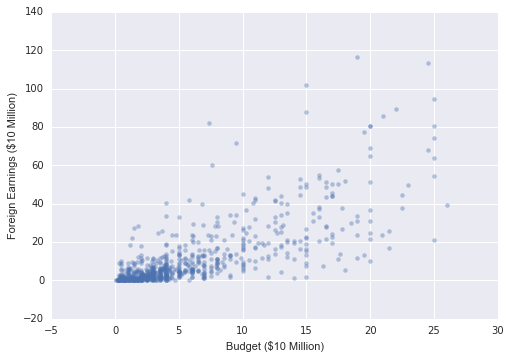

In [116]:
sns.regplot(movie_features['BUDGET'],movie_target,fit_reg=False,scatter_kws={'alpha':0.4})
sns.axlabel('Budget ($10 Million)','Foreign Earnings ($10 Million)')

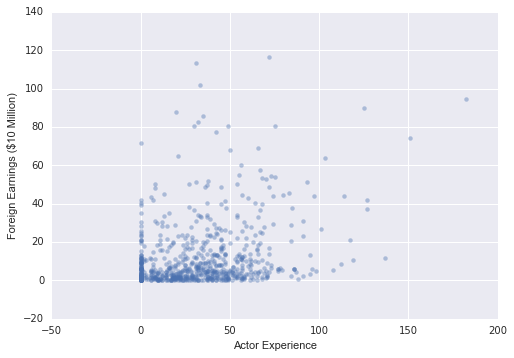

In [117]:
sns.regplot(movie_features['ACTOR_EXP'],movie_target,fit_reg=False,scatter_kws={'alpha':0.4})
sns.axlabel('Actor Experience','Foreign Earnings ($10 Million)')

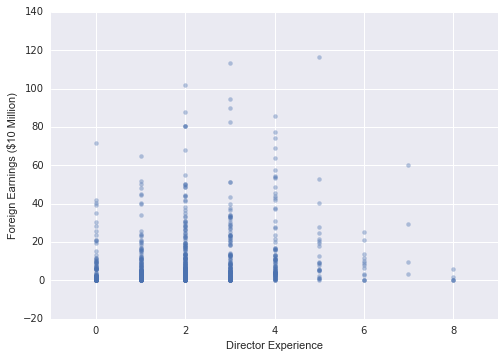

In [118]:
sns.regplot(movie_features['DIRECTOR_EXP'],movie_target,fit_reg=False,scatter_kws={'alpha':0.4})
sns.axlabel('Director Experience','Foreign Earnings ($10 Million)')

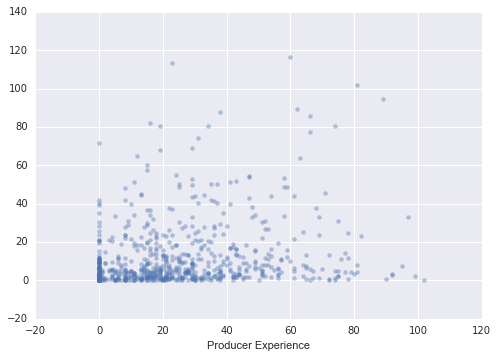

In [119]:
sns.regplot(movie_features['PRODUCER_EXP'],movie_target,fit_reg=False,scatter_kws={'alpha':0.4})
sns.axlabel('Producer Experience','')

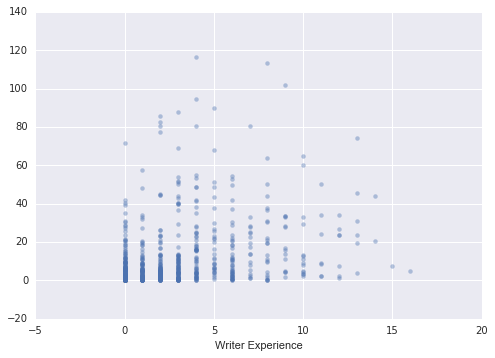

In [120]:
sns.regplot(movie_features['WRITER_EXP'],movie_target,fit_reg=False,scatter_kws={'alpha':0.4})
sns.axlabel('Writer Experience','')

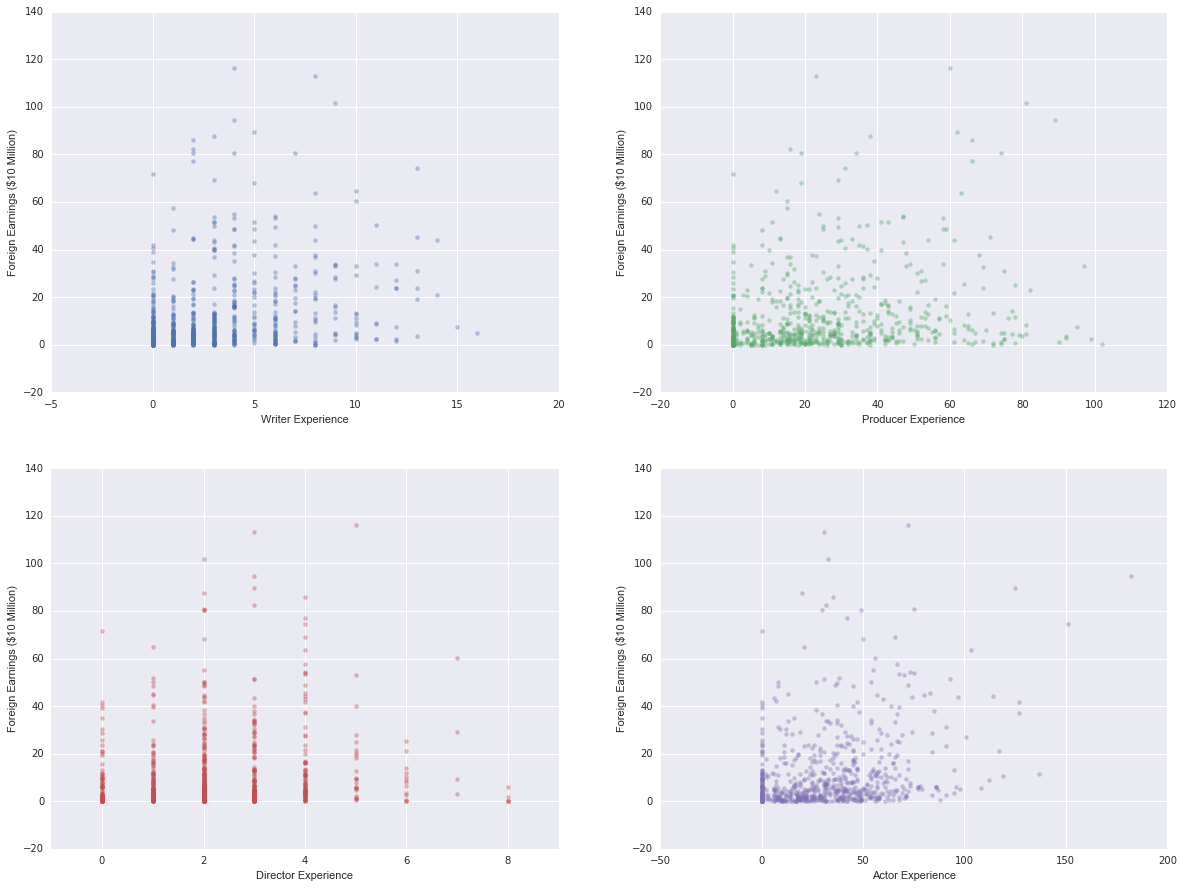

In [155]:
f, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2,2)

sns.regplot(movie_features['WRITER_EXP'],movie_target,fit_reg=False,scatter_kws={'alpha':0.4},ax=ax1)
ax1.set_xlabel('Writer Experience')
ax1.set_ylabel('Foreign Earnings ($10 Million)')

sns.regplot(movie_features['PRODUCER_EXP'],movie_target,fit_reg=False,scatter_kws={'alpha':0.4},ax=ax2)
ax2.set_xlabel('Producer Experience')
ax2.set_ylabel('Foreign Earnings ($10 Million)')

sns.regplot(movie_features['DIRECTOR_EXP'],movie_target,fit_reg=False,scatter_kws={'alpha':0.4},ax=ax3)
ax3.set_xlabel('Director Experience')
ax3.set_ylabel('Foreign Earnings ($10 Million)')

sns.regplot(movie_features['ACTOR_EXP'],movie_target,fit_reg=False,scatter_kws={'alpha':0.4},ax=ax4)
ax4.set_xlabel('Actor Experience')
ax4.set_ylabel('Foreign Earnings ($10 Million)')

f.set_size_inches(20,15)

In [162]:
movie_features.columns

Index([u'ACTOR_EXP', u'Action', u'Adventure', u'Animation', u'BUDGET',
       u'Comedy', u'Concert', u'Crime', u'DIRECTOR_EXP', u'DOMESTIC_OPENING',
       u'Documentary', u'Drama', u'Family', u'Fantasy', u'Foreign',
       u'Historical', u'Horror', u'IMAX', u'Music', u'Musical',
       u'PRODUCER_EXP', u'Period', u'Romance', u'Romantic', u'Sci-Fi',
       u'Sports', u'Thriller', u'WRITER_EXP', u'War', u'Western',
       u'RELEASE_QUARTER_1', u'RELEASE_QUARTER_2', u'RELEASE_QUARTER_3',
       u'RELEASE_QUARTER_4'],
      dtype='object')

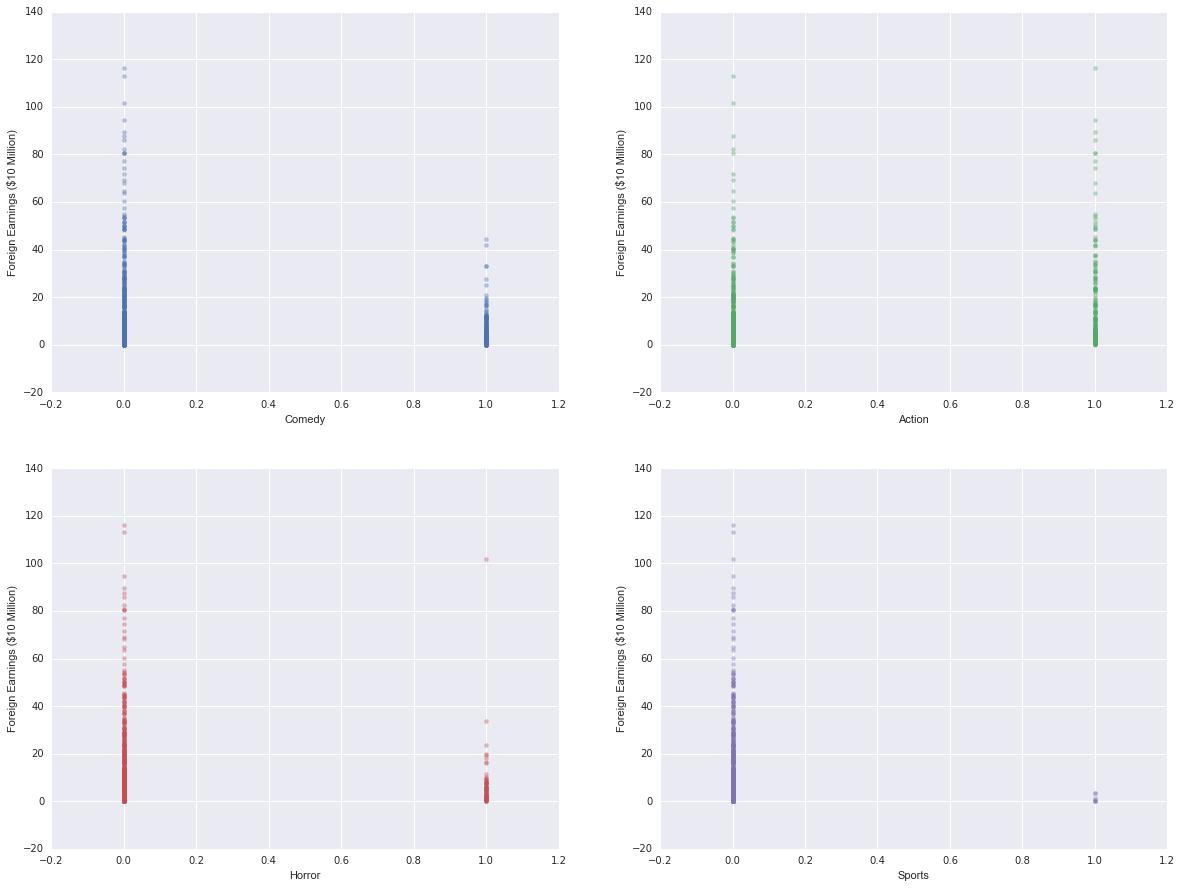

In [166]:
f, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2,2)

sns.regplot(movie_features['Comedy'],movie_target,fit_reg=False,scatter_kws={'alpha':0.4},ax=ax1)
ax1.set_xlabel('Comedy')
ax1.set_ylabel('Foreign Earnings ($10 Million)')

sns.regplot(movie_features['Action'],movie_target,fit_reg=False,scatter_kws={'alpha':0.4},ax=ax2)
ax2.set_xlabel('Action')
ax2.set_ylabel('Foreign Earnings ($10 Million)')

sns.regplot(movie_features['Horror'],movie_target,fit_reg=False,scatter_kws={'alpha':0.4},ax=ax3)
ax3.set_xlabel('Horror')
ax3.set_ylabel('Foreign Earnings ($10 Million)')

sns.regplot(movie_features['Sports'],movie_target,fit_reg=False,scatter_kws={'alpha':0.4},ax=ax4)
ax4.set_xlabel('Sports')
ax4.set_ylabel('Foreign Earnings ($10 Million)')

f.set_size_inches(20,15)

# Start some modeling
### Split the data into features and targets



In [293]:
from sklearn import linear_model
from sklearn import cross_validation
from sklearn.cross_validation import cross_val_predict, train_test_split,KFold, cross_val_score

# Training, Testing, and holdout splits

#### nh means "not holdout"

### Make a holdout set from the data (dropping domestic opening)

In [294]:
movie_features_nh, movie_features_holdout, movie_target_nh, movie_target_holdout = cross_validation.train_test_split(movie_features.drop(['DOMESTIC_OPENING'],axis=1),movie_target,
                                                            test_size=0.1)

### Now split the data into the train and test sets (within the non-holdout data) and create the model

In [295]:
movie_features_train, movie_features_test, movie_target_train, movie_target_test = cross_validation.train_test_split(
                                                            movie_features_nh,movie_target_nh,
                                                            test_size=0.3)

In [296]:
shuffler = cross_validation.ShuffleSplit(len(movie_features_train),n_iter=10,test_size=0.1)
kfold = KFold(len(movie_features_train),n_folds=10)

## Train out of the box linear regression (without domestic opening)

In [297]:
lr_vanilla = linear_model.LinearRegression()
lr_vanilla.fit(movie_features_train,movie_target_train)
print "vanilla lin reg score: ", lr_vanilla.score(movie_features_test, movie_target_test)

# get cross val scores:
scores = cross_val_score(lr_vanilla,movie_features_train,movie_target_train,cv=kfold)
mean_score_lr = np.mean(scores)
print "cross val scores: ",scores
print
print "mean cross vall score: ",mean_score_lr

vanilla lin reg score:  0.507072724288
cross val scores:  [ 0.62155047  0.3740294   0.35637161  0.50444968  0.45627663  0.59194466
  0.68177145  0.4906933   0.59764856  0.47897895]

mean cross vall score:  0.515371470671


# Run on holdout set

In [298]:
lr_vanilla.score(movie_features_holdout,movie_target_holdout)

0.70253802714492775

# Random Forest

In [270]:
len(movie_features.columns)

33

In [271]:
from sklearn.ensemble import RandomForestRegressor

In [272]:
rf = RandomForestRegressor(n_estimators=1000,max_features=25)
rf.fit(movie_features_train,movie_target_train)
print "Random Forest result with no domestic information: ", rf.score(movie_features_test,movie_target_test)

rf_scores = cross_val_score(rf,movie_features_train,movie_target_train,cv=kfold)
mean_score_rf = np.mean(rf_scores)
print "cross val scores: ", rf_scores
print "mean cross val score: ",mean_score_rf


# rf = RandomForestRegressor(n_estimators=1000,max_features=25)
# rf.fit(movie_features_train,movie_target_train)
# print "Random Forest result with domestic information: ", rf.score(movie_features_test,movie_target_test)



Random Forest result with no domestic information:  0.471194175581
cross val scores:  [ 0.60535688  0.53405908  0.41672985  0.77719876  0.576964    0.50041497
  0.44576382  0.35322122  0.54445011  0.70341408]
mean cross val score:  0.545757277662


In [273]:
# test on holdout set
score = rf.score(movie_features_holdout, movie_target_holdout)
print "holdout test: ", score

holdout test:  0.47843356305


In [274]:
rf = RandomForestRegressor(n_estimators=1000,max_features=30)
rf.fit(movie_features_train,movie_target_train)
print "Random Forest result with no domestic information: ", rf.score(movie_features_test,movie_target_test)

rf_scores = cross_val_score(rf,movie_features_train,movie_target_train,cv=kfold)
mean_score_rf = np.mean(rf_scores)
print "cross val scores: ", rf_scores
print "mean cross val score: ",mean_score_rf


Random Forest result with no domestic information:  0.464678350467
cross val scores:  [ 0.59383726  0.53028115  0.40053915  0.77593027  0.55826807  0.50430626
  0.4507052   0.31154769  0.52359483  0.6885593 ]
mean cross val score:  0.533756918364


In [275]:
score = rf.score(movie_features_holdout, movie_target_holdout)
print "holdout test: ", score

holdout test:  0.466708005782


# Gradient Boost

In [276]:
from sklearn.ensemble import GradientBoostingRegressor

In [277]:
grad_boost = GradientBoostingRegressor(n_estimators=200,learning_rate=0.1,alpha=0.3,loss='lad')

grad_boost.fit(movie_features_train,movie_target_train)
grad_boost.score(movie_features_test,movie_target_test)

scores = cross_val_score(grad_boost,movie_features_train,movie_target_train)
print np.mean(scores)

0.544922612245


In [278]:
grad_boost.score(movie_features_holdout, movie_target_holdout)

0.51539190431278614

In [279]:
grad_boost_2 = GradientBoostingRegressor(n_estimators=400,learning_rate=0.1,alpha=0.3,loss='lad')

grad_boost_2.fit(movie_features_train,movie_target_train)
grad_boost_2.score(movie_features_test,movie_target_test)

scores_2 = cross_val_score(grad_boost_2,movie_features_train,movie_target_train)
print np.mean(scores)

0.544922612245


In [280]:
grad_boost = GradientBoostingRegressor(n_estimators=200,learning_rate=0.1,alpha=0.3,loss='huber')

grad_boost.fit(movie_features_train,movie_target_train)
grad_boost.score(movie_features_test,movie_target_test)

scores = cross_val_score(grad_boost,movie_features_train,movie_target_train)
print np.mean(scores)

0.524708761575


# Grid Searching Parameters

In [281]:
from sklearn import grid_search

## Linear Regression

In [299]:
models = {}
models['lin_reg'] = linear_model.LinearRegression()
models['ridge'] = linear_model.Ridge()
models['lasso'] = linear_model.Lasso(alpha = 2) # ran this normally...alpha =2 kills more features than default
models['elastic'] = linear_model.ElasticNet()
models['elasticCV'] = linear_model.ElasticNetCV()
models['larscv'] = linear_model.LarsCV()
models['lassoCV'] = linear_model.LassoCV()

Model: ridge
Score: 0.519203233059
Model: elastic
Score: 0.553771021526
Model: lin_reg
Score: 0.507072724288
Model: lassoCV
Score: 0.554282039413
Model: lasso
Score: 0.554780221624
Model: larscv
Score: 0.56180890254
Model: elasticCV
Score: 0.559021850765


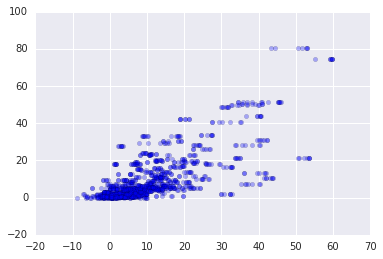

In [300]:
# and lol remember that dictionaries are NOT ordered
for name,model in models.iteritems():
    model.fit(movie_features_train,movie_target_train)
    print('Model: '+name)
    preds = model.predict(movie_features_test)
    plt.scatter(preds,movie_target_test, alpha=0.3)
    plt.show
    print('Score: ' + str(model.score(movie_features_test,movie_target_test)))
    preds = model.predict(movie_features_test)
#     plt.scatter(preds,movie_target_test, alpha=0.3)
#     plt.show

# want to see the effect of normalizing and different parameters
# np.logspace selects numbers evenly from -4 to -0.1 (on log scale, goes from 10^4 to 10^0.1)

In [301]:
lassoCV = linear_model.LassoCV()
lassoCV.fit(movie_features_train,movie_target_train)
preds = lassoCV.predict(movie_features_test)
# plt.scatter(preds,movie_target_test,alpha=0.3)
print "lassoCV score: ", lassoCV.score(movie_features_test,movie_target_test)
scores = cross_val_score(lassoCV,movie_features_train,movie_target_train)
print "lassoCV cross val scores: ",scores
print "mean lassoCV cross val scores: ",np.mean(scores)
print "holdout performance: ", lassoCV.score(movie_features_holdout,movie_target_holdout)

lassoCV score:  0.554282039413
lassoCV cross val scores:  [ 0.48903449  0.56588954  0.5994823 ]
mean lassoCV cross val scores:  0.551468776097
holdout performance:  0.709286710297


In [302]:
lasso = linear_model.Lasso()

parameters = {'normalize':(True,False),'alpha':np.logspace(-4,-.1,30)}
grid_searcher = grid_search.GridSearchCV(lasso,parameters)
grid_searcher.fit(movie_features_train,movie_target_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'normalize': (True, False), 'alpha': array([  1.00000e-04,   1.36296e-04,   1.85766e-04,   2.53191e-04,
         3.45089e-04,   4.70342e-04,   6.41057e-04,   8.73734e-04,
         1.19086e-03,   1.62310e-03,   2.21222e-03,   3.01516e-03,
         4.10954e-03,   5.60113e-03,   7.63411e-03...    1.68883e-01,   2.30181e-01,   3.13727e-01,   4.27597e-01,
         5.82797e-01,   7.94328e-01])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [303]:
grid_searcher.best_params_

{'alpha': 0.035906445401860804, 'normalize': True}

In [304]:
best_lasso_model = grid_searcher.best_estimator_

In [305]:
best_lasso_model.score(movie_features_test,movie_target_test)

0.56073775512841983

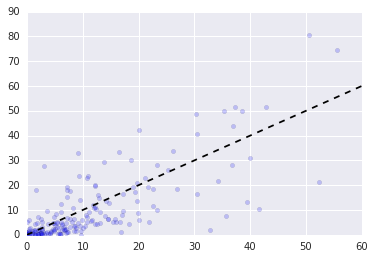

In [306]:
temp = np.linspace(0,600000000,7000)

preds = best_lasso_model.predict(movie_features_test)
plt.scatter(preds,movie_target_test,alpha=0.2)
plt.xlim(0)
plt.ylim(0)
plt.plot(temp,temp,'k--')

In [307]:
import seaborn as sns

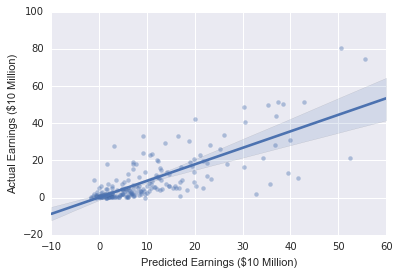

In [308]:

sns.regplot(preds,movie_target_test,scatter_kws={'alpha':0.4})
sns.axlabel('Predicted Earnings ($10 Million)', 'Actual Earnings ($10 Million)')
# f.set_size_inches(10,10)
# sns.yaxis.set_major_locator(10)
# sns.xlim(0)
# sns.ylim(0)

In [309]:
sorted_features = sorted(zip(movie_features_train,model.coef_),
                         key=lambda tup: abs(tup[1]),reverse=True) 
# reverse makes it go from positive to negative...doesnt mean importance though~~~~~!!!!!
for feature in sorted_features:
    print(feature)
print # get some spacing

('BUDGET', 2.1376512359741393)
('Animation', 1.2357868000600449)
('Comedy', -1.1739557873552848)
('RELEASE_QUARTER_1', -0.5648010547429333)
('Drama', -0.46998969299620458)
('Romance', 0.46696721362030508)
('Sci-Fi', 0.42589849691148485)
('RELEASE_QUARTER_4', 0.39845338869353486)
('Horror', 0.067060121461009065)
('ACTOR_EXP', 0.056368899831319763)
('DIRECTOR_EXP', 0.042180925119849597)
('RELEASE_QUARTER_2', 0.016209145758296933)
('PRODUCER_EXP', 0.010196387320932145)
('WRITER_EXP', 0.005124757438624828)
('Action', -0.0)
('Adventure', -0.0)
('Concert', 0.0)
('Crime', -0.0)
('Documentary', 0.0)
('Family', 0.0)
('Fantasy', 0.0)
('Historical', -0.0)
('IMAX', 0.0)
('Music', 0.0)
('Musical', -0.0)
('Period', -0.0)
('Romantic', -0.0)
('Sports', -0.0)
('Thriller', -0.0)
('War', -0.0)
('Western', -0.0)
('RELEASE_QUARTER_3', -0.0)



In [310]:
scores = cross_val_score(best_lasso_model, movie_features_train,movie_target_train,cv=kfold)

In [311]:
print ("scores: ",scores)
print "avg score: ", np.mean(scores)

('scores: ', array([ 0.58523161,  0.37724955,  0.33498442,  0.54434964,  0.45555128,
        0.58415804,  0.70994249,  0.51575915,  0.64211427,  0.54734914]))
avg score:  0.529668958518


In [312]:
best_lasso_model.score(movie_features_holdout,movie_target_holdout)

0.69995577966366263

# Doing the actor/director/producer/writer experience thing bumped my scores for lin reg up ~10%